In [1]:
import fuzzingbook_utils

# Project 1 - Mutation Fuzzing

The goal of this project is to utilize mutation fuzzing to cover as much code as possible during testing.

The target is the [svglib](https://pypi.org/project/svglib/) SVG rendering library written in python.

For an easier integration the library we provide a wrapped function __parse_svg(string)__, which receives a string with the SVG content and invokes the parsing library. 

To ensure that all converted elements are correct, the wrapper function internally converts the parsed SVG into PDF and PNG formats. Finally, the wrapper function returns an _RLG Drawing_ object, which can be discarded.

<!-- ### Available functionality in the project package: 

1. All required functionality is in the package "project_utils/project1"
    
2. The initial seed can be obtained by the __get_seed()__ function
    
3. Each SVG can be converted into an [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) with the function __svg_to_tree(string)__. This functions returns the tree's root.

4. An [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) can be converted back into a string using __tree_to_string(root)__ function

5. The class [Coverage](notebooks/Coverage.ipynb) allows for coverage monitoring.

### Site notes:

1. Overall seed coverage is 4083 statements.
2. The __parse_svg(string)__ function has no error handling and any exception trown by the library will be propagated to the caller.
3. Mutations can be applied nodes or parts of a node. -->
<!-- 4. Tests reach an overall of 8498 unique statements -->

In [2]:
import logging
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

# Required to run svglib on Python3
xrange = range

def parse_svg(data):
    try:
        with open("tmp.svg", "w") as f:
            f.write(data)

        logging.disable(logging.WARNING)
        drawing = svg2rlg("tmp.svg")
        #logging.enable(logging.WARNING)

        assert(drawing is not None)

        pdf_file = 'tmp.pdf'
        png_file = 'tmp.png'    
        renderPDF.drawToFile(drawing, pdf_file)
        renderPM.drawToFile(drawing, png_file)
        return drawing
    finally:
        if os.path.exists("tmp.svg"):
            os.remove("tmp.svg")
            
        if os.path.exists("tmp.png"):
            os.remove("tmp.png")
            
        if os.path.exists("tmp.pdf"):
            os.remove("tmp.pdf")            

## Auxiliary functions

In order to aid the fuzzer's implementation we provide the following auxiliary functions aimed at converting SVG string representations into Python's [ElementTree](https://docs.python.org/2/library/xml.etree.elementtree.html).

In [3]:
import sys
import os
from lxml import etree

def svg_as_tree(data):
    """Converts a String representation of an SVG into an ElementTree and returns its root

    :param data: String representation of an SVG
    :return: ElementTree https://docs.python.org/3/library/xml.etree.elementtree.html
    """
    parser = etree.XMLParser()
    root = etree.fromstring(data, parser=parser)
    return root

The tree representation can be used to apply mutations on internal components of the nodes, as well as move, add or remove elements. The following code illustrates how to convert from a String into an [ElementTree](https://docs.python.org/2/library/xml.etree.elementtree.html).

In [4]:
svg_string = """<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 100 100">
  <path d="M19,19h58v58h-58z" stroke="#000" fill="none" stroke-width="4"/>
  <path d="M17,30l19-12l43,54l-17,15zM14,84c12-20 46-61 61-72l13,19 c-17,10-50,50-60,64z" fill="#C30" stroke-linejoin="round" stroke-width="6" stroke="#C30"/>
</svg>
"""
root_node = svg_as_tree(svg_string)
print("%s - %s" % (root_node.tag, root_node.attrib))

{http://www.w3.org/2000/svg}svg - {'viewBox': '0 0 100 100'}


After converting the String representation into a tree it is possible ot iterate over the nodes

In [5]:
# Printing immediate child nodes:
for child in root_node:
    print("%s - %s" % (child.tag, child.attrib))

{http://www.w3.org/2000/svg}path - {'d': 'M19,19h58v58h-58z', 'stroke': '#000', 'fill': 'none', 'stroke-width': '4'}
{http://www.w3.org/2000/svg}path - {'d': 'M17,30l19-12l43,54l-17,15zM14,84c12-20 46-61 61-72l13,19 c-17,10-50,50-60,64z', 'fill': '#C30', 'stroke-linejoin': 'round', 'stroke-width': '6', 'stroke': '#C30'}


As well are access and manipulate the node type (_tag_) and its attributes (_attrib_)

In [6]:
# Accessing and chancing properties
first_child = root_node[0]
print("old value of stroke-width: %s" % first_child.attrib['stroke-width'])

first_child.attrib['stroke-width'] = "99"
print("new value of stroke-width: %s" % first_child.attrib['stroke-width'])

old value of stroke-width: 4
new value of stroke-width: 99


After the changes the tree can be converted back into a string to be used in _parse_svg()_ function.

In [7]:
new_string = etree.tostring(root_node)
print(new_string)

b'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 100 100">\n  <path d="M19,19h58v58h-58z" stroke="#000" fill="none" stroke-width="99"/>\n  <path d="M17,30l19-12l43,54l-17,15zM14,84c12-20 46-61 61-72l13,19 c-17,10-50,50-60,64z" fill="#C30" stroke-linejoin="round" stroke-width="6" stroke="#C30"/>\n</svg>'


## Fuzzer template

The basic template from our fuzzer is based on the [MutationCoverageFuzzer](MutationFuzzer.ipynb).

This template automatically loads a set of 10 SVG files as an initial seed.

In [8]:
from Coverage import Coverage, population_coverage
from MutationFuzzer import MutationCoverageFuzzer, FunctionCoverageRunner

In [9]:
class Project1MutationCoverageFuzzer(MutationCoverageFuzzer):
    def __init__(self, min_mutations=2, max_mutations=10):
        seed = self.__get_initial_seed()
        super(Project1MutationCoverageFuzzer, self).__init__(seed, min_mutations, max_mutations)

    def __get_initial_seed(self):
        """Gets the initial seed for the fuzzer

        :return: List of SVG in string format
        """

        seed_dir = "./data/svg/"
        seed_files = list(filter(lambda f: ".svg" in f, os.listdir(seed_dir)))

        seed = []
        for f in seed_files:
            print(seed_dir + f)
            with open(seed_dir + f) as x:
                s = ''.join(x.readlines()).strip()
                seed.append(s)

        print("Seed size: " + str(len(seed)) + " files")
        return seed

## Fuzzing the _svglib_

To fuzz _svglib_ it must execute it and inspect the obtained coverage. We will reuse the [FunctionCoverageRunner](MutationFuzzer.ipynb) class from the lecture to perform this task.

In [10]:
parse_svg_runner = FunctionCoverageRunner(parse_svg)

We then initialize our fuzzer

In [11]:
mutation_fuzzer = Project1MutationCoverageFuzzer()

./data/svg/rg1024_green_grapes.svg
./data/svg/oscon.svg
./data/svg/no.svg
./data/svg/lineargradient2.svg
./data/svg/ubuntu.svg
./data/svg/facebook.svg
./data/svg/dojo.svg
./data/svg/irony.svg
./data/svg/yadis.svg
./data/svg/USStates.svg
Seed size: 10 files


And execute it multiple times to test it.

In [12]:
mutation_fuzzer.reset()
mutation_fuzzer.runs(runner=parse_svg_runner, trials=1000)

Unable to read the image http://en.oreilly.co,m/oscon2008/public/asset/asset/765. Skipping...
Unable to read the image http://en.oreilly.co,m/oscon2008/publi'c?asset/asset/765. Skipping...
Unable to read the image htt://en.oreilly.com/oscon008/public/assLet/asset/765. Skipping...
Unable to read the image htt://en.oreilly.com/oscon008/public/assLet/asset/765. Skipping...


 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Obtaining the population coverage

In order to obtain the overal coverage achieved by the fuzzer's population we will exploit the [population_coverage](Coverage.ipynb) function from the lecture.

The following code calculates the overall coverage from a fuzzer's population:

In [13]:
from Coverage import population_coverage
import matplotlib.pyplot as plt

Unable to read the image http://en.oreilly.co,m/oscon2008/public/asset/asset/765. Skipping...
Unable to read the image http://en.oreilly.co,m/oscon2008/publi'c?asset/asset/765. Skipping...
Unable to read the image htt://en.oreilly.com/oscon008/public/assLet/asset/765. Skipping...
Unable to read the image htt://en.oreilly.com/oscon008/public/assLet/asset/765. Skipping...


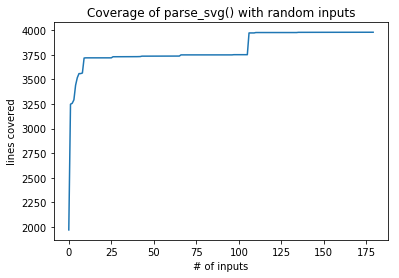

In [14]:
all_coverage, cumulative_coverage = population_coverage(
    mutation_fuzzer.population, parse_svg)

plt.plot(cumulative_coverage)
plt.title('Coverage of parse_svg() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');